<a href="https://colab.research.google.com/github/hrbolek/learning/blob/master/operanalyst/shosim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Teorie hromadné obsluhy

## Teorie

### Otázky k vyřešení

- Jak dlouhá bude fronta?
- Jak dlouho se ve frontě čeká?
- Jaká je pravděpodobnost, že obsluha je volná / nepracuje?

### Rozdělení

- Systémy s čekáním. Požadavek, zákazník, letoun, apod. se zařadí do fronty a čeká na obsluhu.
- Systémy s odmítnutím. Požadavek otestuje dostupnost obsluhy a jestliže není obsloužen, systém opouští (letoun).

- Systémy s odchodem. Po určité době požadavek systém opouští, aniž by byl obsloužen.

## Krátké připomenutí
Kandalova notace

Systémy M/M/1, M/M/n

Pro systém M/M/1 platí rovnice o průměrné délce fronty

$L = \frac{\lambda}{\mu}$

kde L je  průměrná délka fronty

$\lambda$ je intenzita toku požadavků

$\mu$ je intenzita obsluhy

odkaz https://en.wikipedia.org/wiki/Queueing_theory

## Simulace toku požadavků

### Poisonův tok

Poisonův tok je model např. příchodu zákazníků k přepážce, kde jsou obsluhováni. Pro modelování potřebujeme generovat posloupnost příchodů. Interval mezi jednotlivými příchody lze generovat podle následujícího vztahu

$r'=-\frac{1}{\lambda}ln(r)$

kde $r$ je náhodné číslo s rovnoměrným rozložením a $r'$ je náhodný interval mezi dvěma příchody.

Stejným vztahem lze vypočítat náhodnou délku obsluhy (pro systémy M/M/1 nebo M/M/n)

https://preshing.com/20111007/how-to-generate-random-timings-for-a-poisson-process/

In [28]:
import numpy as np
from numpy.random import Generator, exponential

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [29]:
from random import random
from math import log as ln

def rndEx(rnd, lam):
  x = rnd()
  result = (-1 / lam) * ln(x) #https://preshing.com/20111007/how-to-generate-random-timings-for-a-poisson-process/
  return result

### Graf četností

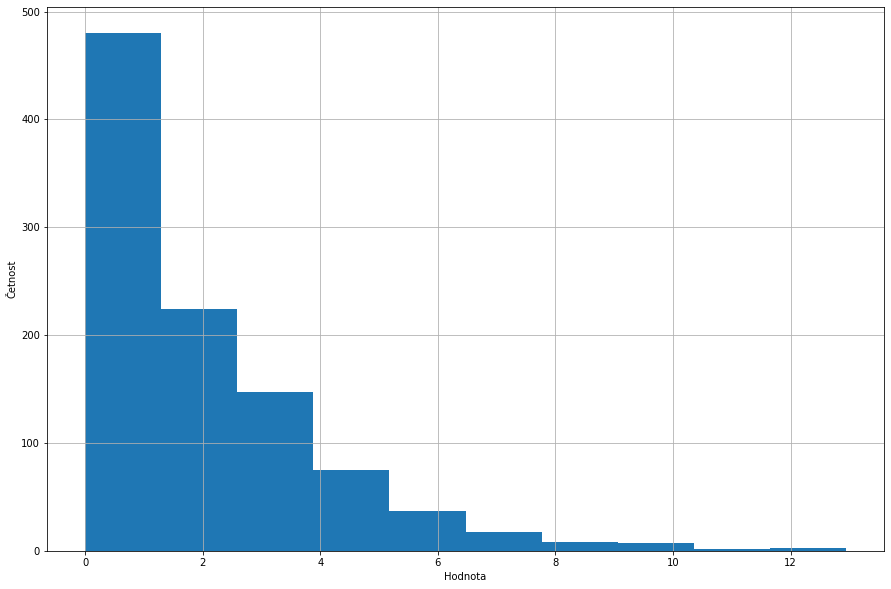

In [30]:
lam = 0.5
data = exponential(1 / lam, 1000)
plt.hist(data)
plt.grid('both')
plt.xlabel('Hodnota')
plt.ylabel('Četnost');

### Časová posloupnost / vznik požadavků

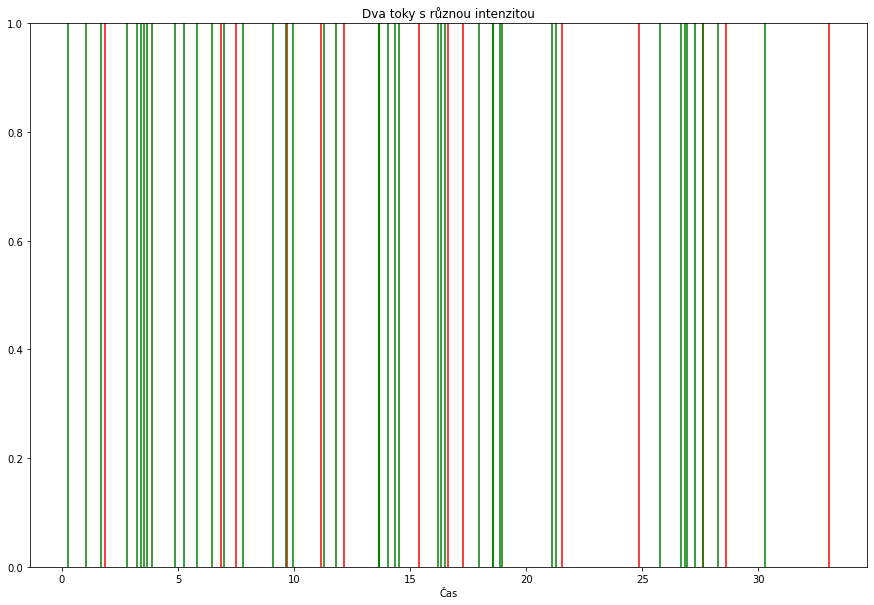

In [31]:
def plotFlow(maxTime, lam, color):
  currentTime = 0
  while currentTime < maxTime:
    currentTime = currentTime + rndEx(random, lam)
    plt.axvline(x = currentTime, color =color)

plotFlow(30, 0.5, color='red')    
plotFlow(30, 1, color='green')    
plt.title('Dva toky s různou intenzitou')
plt.xlabel('Čas');

In [32]:
def generateSequence(maxTime, lam):
  result = []
  currentTime = 0
  while currentTime < maxTime:
    currentTime = currentTime + rndEx(random, lam)
    result.append(currentTime)
  return result

## Událostní kalendář pro událostní simulaci

Třída pro událostní simulaci. Událostní simulace umožňuje spouštění událostí - akcí v časové souslednosti bez ohledu na souslednost plánování.

In [33]:
class EventCalendar:
  def __init__(self):
    self._queue = []
    pass

  #Metoda pro vykonání jednoho kroku simulace
  def Step(self):
    #z fronty odstraň nejstarší událost
    currentEvent = self._queue.pop(0)

    #vyvolej funkci, která je spojena s danou událostí
    func = currentEvent['executor']
    time = currentEvent['time']
    result = func(time, **currentEvent['kwargs'])
    
    currentEvent['result'] = result
    #vrať událost, která byla zpracována
    return currentEvent

  #Metoda pro získání informace o času nejstarší události, 
  #tj. události, která bude zpracována jako první
  def PrepareNext(self):
    #vrať čas nejstarší události
    return self._queue[0]['time']

  #Vložení události do fronty událostí, 
  #futureTime - čas, kdy bude událost vyvolána
  #f - funkce, která bude v čase události vykonána / volána
  def AddEvent(self, futureTime, f, **kwargs):
    self._queue.append({'time': futureTime, 'executor': f, 'kwargs': kwargs})
    #setřídit frontu / list událostí podle položky time / čas
    self._queue.sort(key = lambda item: item['time'])
    return self

  def __iter__(self):  # we can return self here, because __next__ is implemented
      return self

  def __next__(self):
    return self.Step()


### Použití událostní simulace

In [34]:
calendar = EventCalendar()

def eventPrinter(time, calendar, value):
  print(f'At time\t{time}\tvalue is\t{value}')
  calendar.AddEvent(time + random(), eventPrinter, calendar = calendar, value = value + 1)

calendar.AddEvent(0, eventPrinter, calendar = calendar, value = 0)

for event in calendar:
  print(f"I have served event in time {event['time']}")
  if event['time'] > 5:
    break

At time	0	value is	0
I have served event in time 0
At time	0.9988702765418007	value is	1
I have served event in time 0.9988702765418007
At time	1.765805286757355	value is	2
I have served event in time 1.765805286757355
At time	2.41241247555083	value is	3
I have served event in time 2.41241247555083
At time	2.4855819115203093	value is	4
I have served event in time 2.4855819115203093
At time	3.2450511064189986	value is	5
I have served event in time 3.2450511064189986
At time	4.0499725465347725	value is	6
I have served event in time 4.0499725465347725
At time	4.6264129209151985	value is	7
I have served event in time 4.6264129209151985
At time	4.7742244858771565	value is	8
I have served event in time 4.7742244858771565
At time	5.6649309349369545	value is	9
I have served event in time 5.6649309349369545


## Simulace SHO M/M/1

In [35]:
λ = 1
µ = 2

### Příchod požadavku

In [36]:
queue = []
def customerArrived(time, calendar):
  deltaTime = exponential(1 / λ, 1)[0] #jeden čas
  calendar.AddEvent(time + deltaTime, customerArrived, calendar=calendar)
  calendar.AddEvent(time, tryBeginService, calendar=calendar)
  newCustomer = {'enterTime': time}
  queue.append(newCustomer)

### Obsluha požadavku

In [37]:
servicePlace = {'inService': None}

def tryBeginService(time, calendar):
  if servicePlace['inService'] is None:
    if len(queue) > 0:
      customer = queue.pop()
      timeOfEnd = exponential(1 / µ, 1)[0] #jeden čas
      calendar.AddEvent(time + timeOfEnd, endService, calendar=calendar)
      customer['beginService'] = time
      customer['endService'] = time + timeOfEnd
      servicePlace['inService'] = customer

def endService(time, calendar):
  finishedCustomer = servicePlace['inService']
  servicePlace['inService'] = None
  calendar.AddEvent(time, tryBeginService, calendar=calendar)
  return finishedCustomer

### Sběr statistických ukazatelů

#### Délka fronty

In [38]:
queueStatistic = {'cumulativeValue': 0, 'value': 0, 'time': 0}
def checkQueueLength(time):
  deltaTime = time - queueStatistic['time']
  queueStatistic['time'] = time
  queueStatistic['cumulativeValue'] += deltaTime * queueStatistic['value']
  queueStatistic['value'] = len(queue) 

def getAvgLength():
  if queueStatistic['time'] > 0:
    return queueStatistic['cumulativeValue'] / queueStatistic['time']
  else:
    return 0

#### Obsluha volná

In [39]:
serviceFull = {'cumulativeValue': 0, 'value': 0, 'time': 0}
def checkServiceFull(time):
  deltaTime = time - serviceFull['time']
  serviceFull['time'] = time
  serviceFull['cumulativeValue'] += deltaTime * serviceFull['value']
  serviceFull['value'] = 0
  if servicePlace['inService'] is None:
    serviceFull['value'] = 1

def getServiceAvailableProbability():
  if serviceFull['time'] > 0:  
    return serviceFull['cumulativeValue'] / serviceFull['time']    
  else:
    return 0

#### Obecný tvar pro libovolnou statistiku

In [40]:
def createStatistic(valueGetter):
  data = {'cumulativeValue': 0, 'value': 0, 'time': 0}
  def collectData(time):
    deltaTime = time - data['time']
    data['time'] = time
    data['cumulativeValue'] += deltaTime * data['value']
    data['value'] = valueGetter()

  def getValue():
    if data['time'] > 0:  
      return data['cumulativeValue'] / data['time']    
    else:
      return 0  
  return collectData, getValue

In [41]:
def decideIfLengthGT5():
  if len(queue) > 5:
    return 1
  else:
    return 0

updateLengthGT5, getLengthGT5 = createStatistic(decideIfLengthGT5)

### Běh simulace

In [42]:
calendar = EventCalendar()

times = []
lengths = []
probability = []

calendar.AddEvent(0, customerArrived, calendar=calendar)
for event in calendar:
  #print(event)
  currentTime = event['time']
  checkQueueLength(currentTime)
  checkServiceFull(currentTime)

  times.append(currentTime)
  lengths.append(getAvgLength())
  probability.append(getServiceAvailableProbability())

  finishedCustomer = event['result']
  if not finishedCustomer is None:
    pass
  if event['time'] > 10000:
    break

### Výsledek simulace

#### Textový výstup

In [43]:
print(f'Průměrná délka fronty je {getAvgLength()}')
print(f'Pravděpodobnost, že obsluha bude volná {getServiceAvailableProbability()}')

Průměrná délka fronty je 0.4597000367351561
Pravděpodobnost, že obsluha bude volná 0.5075072669019897


#### Délka fronty

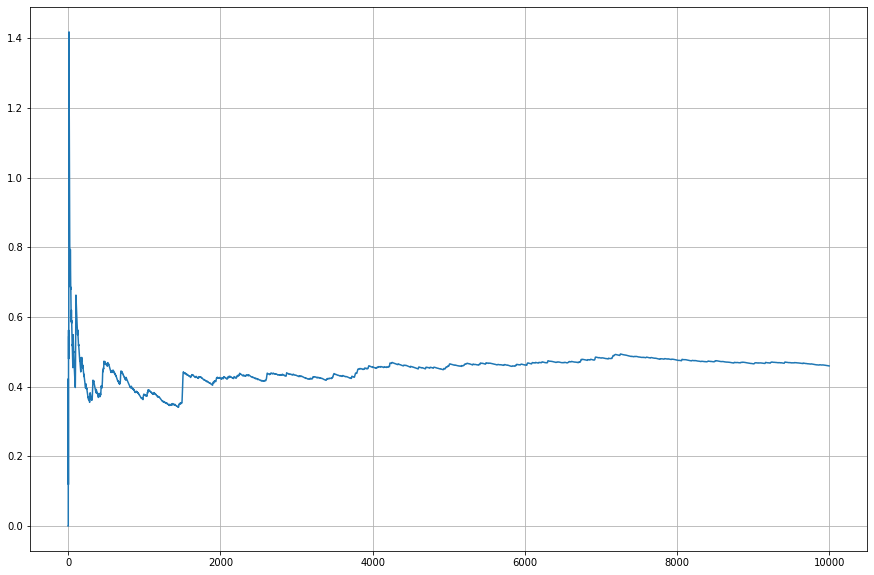

In [44]:
plt.plot(times, lengths)
plt.grid()

#### Pravděpodobnost obsluha je volná

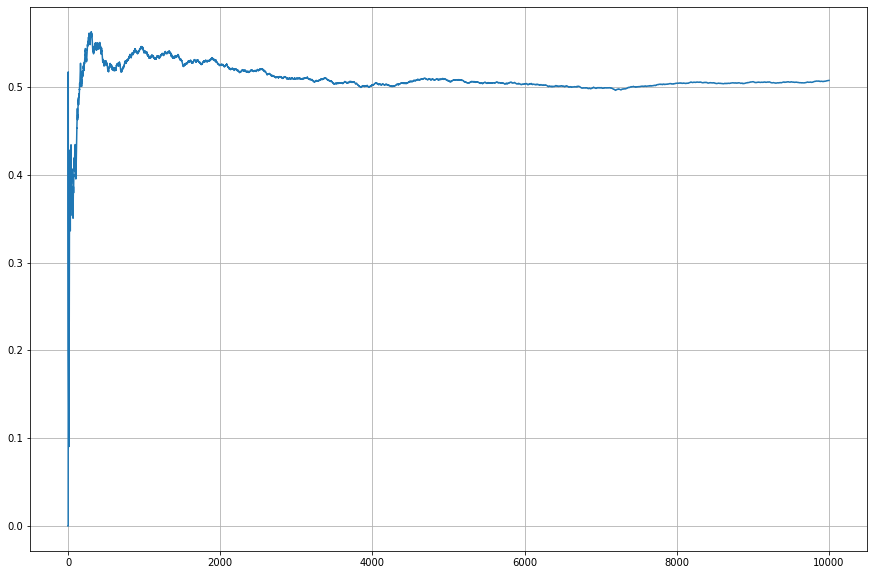

In [45]:
plt.plot(times, probability)
plt.grid()

## Simulace SHO M/M/n

In [46]:
λ = 4
µ = 2
n = 3

### Příchod požadavku

In [47]:
queue = []
def customerArrived(time, calendar):
  deltaTime = exponential(1 / λ, 1)[0] #jeden čas
  calendar.AddEvent(time + deltaTime, customerArrived, calendar=calendar)
  calendar.AddEvent(time, tryBeginService, calendar=calendar)
  newCustomer = {'enterTime': time}
  queue.append(newCustomer)

### Obsluha požadavku

In [48]:
servedRequests = []

def tryBeginService(time, calendar):
  if len(servedRequests) < n:
    if len(queue) > 0:
      customer = queue.pop()
      timeOfEnd = exponential(1 / µ, 1)[0] #jeden čas
      calendar.AddEvent(time + timeOfEnd, endService, calendar=calendar, customer=customer)
      customer['beginService'] = time
      customer['endService'] = time + timeOfEnd
      servedRequests.append(customer)

def endService(time, calendar, customer):
  servedRequests.remove(customer)
  calendar.AddEvent(time, tryBeginService, calendar=calendar)
  return customer

### Sběr statistických ukazatelů

#### Délka fronty

In [49]:
def statQueueLength():
  return len(queue)

updateStatQueueLength, getStatQueueLength = createStatistic(statQueueLength)

#### Obsluha volná

In [50]:
def statServiceFull():
  if len(servedRequests) >= n:
    return 1
  else:
    return 0

updateStatServiceFull, getStatServiceFull = createStatistic(statServiceFull)

### Běh simulace

In [51]:
calendar = EventCalendar()

times = []
lengths = []
probability = []

calendar.AddEvent(0, customerArrived, calendar=calendar)
for event in calendar:
  currentTime = event['time']
  updateStatQueueLength(currentTime)
  updateStatServiceFull(currentTime)

  times.append(currentTime)
  lengths.append(getStatQueueLength())
  probability.append(getStatServiceFull())

  finishedCustomer = event['result']
  if not finishedCustomer is None:
    pass
  if event['time'] > 10000:
    break

### Výsledek simulace

#### Textový výstup

In [52]:
print(f'Průměrná délka fronty je {getStatQueueLength()}')
print(f'Pravděpodobnost, že obsluha bude volná {getStatServiceFull()}')

Průměrná délka fronty je 0.8900550380444455
Pravděpodobnost, že obsluha bude volná 0.4407912160280959


#### Délka fronty

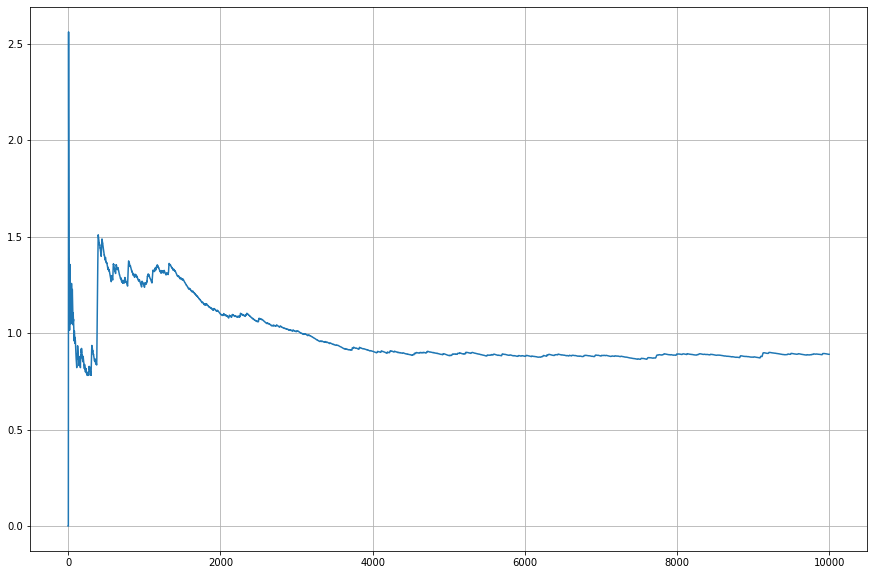

In [53]:
plt.plot(times, lengths)
plt.grid()

#### Pravděpodobnost obsluha je volná

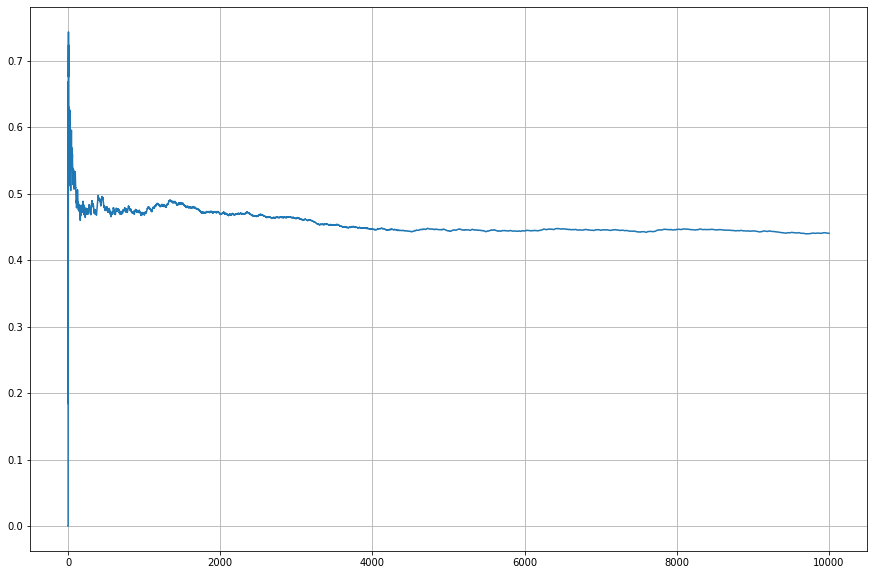

In [54]:
plt.plot(times, probability)
plt.grid()